In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import quad

# S(Q, $\omega$) generation
Costruiamo qui un modello di S(Q, $\omega$) con cui testare l'operazione monte carlo. Questo è un'estrapolazione de degli articoli e vale per il benzene deuterato.

## Costruzione della S(Q, $\omega$)

In [3]:
### S(Q,E) ###
# S(Q)
rawSqd6ext = np.loadtxt('./data_Sq/Sqw_generation/Sq_d-benzeneEXT_paper.csv', delimiter=',')
rawSqd6ext[:,1] -= 2

b = {}
b['D'] = 6.671
b['C'] = 6.6460
c = {}
c['D'] = 6/(6+6)
c['C'] = 6/(6+6)

Sincd6 = (4.04**2/2 + 0/2) * 1e-2

C = 2*c['D']*c['C']*b['D']*b['C'] + 2*c['D']**2*b['D']**2 + 2*c['C']**2*b['C']**2
C = C/(1e2)
Scohd6 = lambda x: np.interp(x, rawSqd6ext[:,0], rawSqd6ext[:,1]+ C)

# Debey-Waller lambda
sigma_DBW = 6
DBW = lambda x: np.exp(-(x)**2/(2*sigma_DBW**2))

# Gamma lambda
def GammaEl(Q):
    if Q < 3: return 1.5*Q
    else: return -4.3 + 3*Q
GammaEl = np.vectorize(GammaEl)

# Inelastic Gamma lambda
GammaInel = lambda Q: 8.54084 * Q

# Population factor lambda
def d_balance_single(E, T):
    kB = 8.617333262e-2 # meV/K
    if E==0:
        return 1
    else:
        return E/(kB*T) * (1/(np.exp(E / (kB*T)) - 1) + 1)
d_balance = np.vectorize(d_balance_single)

Sel = lambda Q, omega: 1/np.pi * (GammaEl(Q) / (omega**2 + GammaEl(Q)**2))

Sinel = lambda Q, E: 1/(3*np.pi*GammaInel(Q)) * (np.arctan(E+3/2*GammaInel(Q)) - np.arctan(E-3/2*GammaInel(Q)))

In [4]:
def S(Q, omega):
    T = 300
    omega_min = -100
    omega_max = 100

    S_tonorm = lambda omega: (DBW(Q) * Sel(Q, omega) + (1-DBW(Q)) * Sinel(Q, omega)) * d_balance(omega, 300)

    norm = quad(S_tonorm, omega_min, omega_max)[0]

    return S_tonorm(omega) / norm * (Scohd6(Q) + Sincd6)

(-2.0, 2.0)

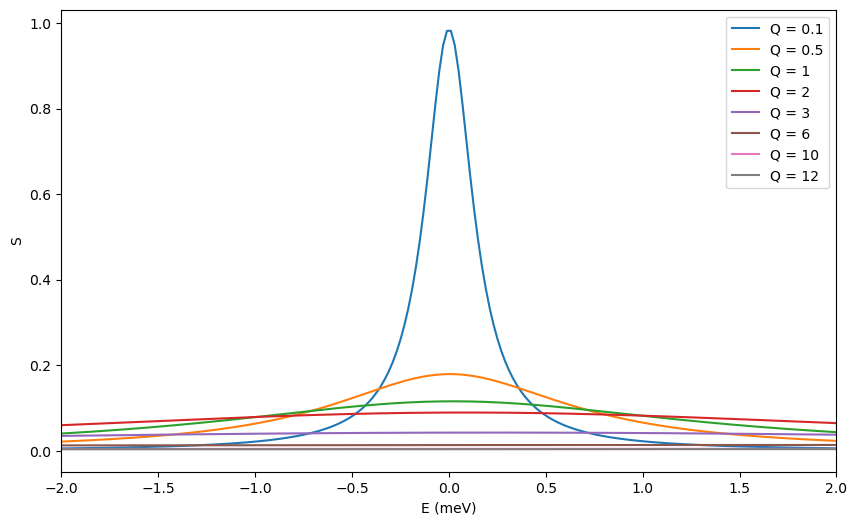

In [5]:
plt.figure(figsize=(10,6))

omega = np.linspace(-100, 100, 10000)
for q in [.1, .5, 1, 2, 3, 6, 10, 12]:
    plt.plot(omega, S(q, omega), label='Q = '+str(q))

plt.xlabel('E (meV)')
plt.ylabel('S')
plt.legend()
#plt.yscale('log')
plt.xlim(-2,2)

## Salvataggio della Mesh su S(Q, $\omega$)

In [6]:
Qmin, Qmax, dQ = .01, 14, .02
omega_min, omega_max, domega = -100, 100, .5

Q_vec = np.arange(Qmin, Qmax, dQ)
omega_vec = np.arange(omega_min, omega_max, domega)


S_mesh = np.array([S(Qmin, omega_vec)])
for q in Q_vec[1:]:
    S_mesh = np.vstack((S_mesh, S(q, omega_vec)))

S_mesh_len = S_mesh.shape[0]*S_mesh.shape[1]

################################################
Q_mesh, omega_mesh = np.meshgrid(Q_vec, omega_vec)
Q_mesh, omega_mesh = Q_mesh.T, omega_mesh.T
dQ_mesh, domega_mesh = Q_vec[1]-Q_vec[0], omega_vec[1]-omega_vec[0]


print('S_mesh dimension:', S_mesh.nbytes/1e6, 'MB')
print('Q_vec:', Q_vec[:10])
print('omega_vec:', omega_vec)
print('Q_mesh: \n',Q_mesh)
print('omega_mesh: \n',omega_mesh)

#################################################

# save
np.save('./data_Sq/Sqw_test/S_mesh.npy', S_mesh)
np.save('./data_Sq/Sqw_test/Q_mesh.npy', Q_mesh)
np.save('./data_Sq/Sqw_test/omega_mesh.npy', omega_mesh)

S_mesh dimension: 2.24 MB
Q_vec: [0.01 0.03 0.05 0.07 0.09 0.11 0.13 0.15 0.17 0.19]
omega_vec: [-100.   -99.5  -99.   -98.5  -98.   -97.5  -97.   -96.5  -96.   -95.5
  -95.   -94.5  -94.   -93.5  -93.   -92.5  -92.   -91.5  -91.   -90.5
  -90.   -89.5  -89.   -88.5  -88.   -87.5  -87.   -86.5  -86.   -85.5
  -85.   -84.5  -84.   -83.5  -83.   -82.5  -82.   -81.5  -81.   -80.5
  -80.   -79.5  -79.   -78.5  -78.   -77.5  -77.   -76.5  -76.   -75.5
  -75.   -74.5  -74.   -73.5  -73.   -72.5  -72.   -71.5  -71.   -70.5
  -70.   -69.5  -69.   -68.5  -68.   -67.5  -67.   -66.5  -66.   -65.5
  -65.   -64.5  -64.   -63.5  -63.   -62.5  -62.   -61.5  -61.   -60.5
  -60.   -59.5  -59.   -58.5  -58.   -57.5  -57.   -56.5  -56.   -55.5
  -55.   -54.5  -54.   -53.5  -53.   -52.5  -52.   -51.5  -51.   -50.5
  -50.   -49.5  -49.   -48.5  -48.   -47.5  -47.   -46.5  -46.   -45.5
  -45.   -44.5  -44.   -43.5  -43.   -42.5  -42.   -41.5  -41.   -40.5
  -40.   -39.5  -39.   -38.5  -38.   -37.5  -37.   -

## Esempio di Load

In [7]:
### LOAD S(Q,E) ###
S_mesh = np.load('./data_Sq/Sqw_test/S_mesh.npy')
Q_mesh = np.load('./data_Sq/Sqw_test/Q_mesh.npy')
omega_mesh = np.load('./data_Sq/Sqw_test/omega_mesh.npy')

omega_vec = omega_mesh[0,:]
Q_vec = Q_mesh[:,0]
Q_vec


array([1.000e-02, 3.000e-02, 5.000e-02, 7.000e-02, 9.000e-02, 1.100e-01,
       1.300e-01, 1.500e-01, 1.700e-01, 1.900e-01, 2.100e-01, 2.300e-01,
       2.500e-01, 2.700e-01, 2.900e-01, 3.100e-01, 3.300e-01, 3.500e-01,
       3.700e-01, 3.900e-01, 4.100e-01, 4.300e-01, 4.500e-01, 4.700e-01,
       4.900e-01, 5.100e-01, 5.300e-01, 5.500e-01, 5.700e-01, 5.900e-01,
       6.100e-01, 6.300e-01, 6.500e-01, 6.700e-01, 6.900e-01, 7.100e-01,
       7.300e-01, 7.500e-01, 7.700e-01, 7.900e-01, 8.100e-01, 8.300e-01,
       8.500e-01, 8.700e-01, 8.900e-01, 9.100e-01, 9.300e-01, 9.500e-01,
       9.700e-01, 9.900e-01, 1.010e+00, 1.030e+00, 1.050e+00, 1.070e+00,
       1.090e+00, 1.110e+00, 1.130e+00, 1.150e+00, 1.170e+00, 1.190e+00,
       1.210e+00, 1.230e+00, 1.250e+00, 1.270e+00, 1.290e+00, 1.310e+00,
       1.330e+00, 1.350e+00, 1.370e+00, 1.390e+00, 1.410e+00, 1.430e+00,
       1.450e+00, 1.470e+00, 1.490e+00, 1.510e+00, 1.530e+00, 1.550e+00,
       1.570e+00, 1.590e+00, 1.610e+00, 1.630e+00, 